In [18]:

import pandas as pd
import wikipedia as wp
html = wp.page("Wikipedia:List_of_Wikipedias").html().encode("UTF-8")
dfs = pd.read_html(html)
print(dfs)

[             Language  Language (local) Wiki  Articles  Total pages  \
0             English           English   en   6981891     62935140   
1             Cebuano           Cebuano  ceb   6116745     11229736   
2              German           Deutsch   de   3006512      8265195   
3              French         franÃ§ais   fr   2677742     13445252   
4             Swedish           svenska   sv   2608461      6305349   
..                ...               ...  ...       ...          ...   
349     Akan (closed)                ak   ak         0         1714   
350   Herero (closed)        Otsiherero   hz         0          175   
351   Kanuri (closed)            kanuri   kr         0          162   
352  Nauruan (closed)    Dorerin Naoero   na         0         1813   
353            Norfuk  Norfuk / Pitkern  pih         0         1033   

          Edits  Admins     Users  Active users   Files  \
0    1281048952     847  49001793        120562  936002   
1      35058991       6    1

The notebook below was written with the help of a Large Language Model agent using Claude 3.7 sonnet. 

In [19]:
import requests

# Define the SPARQL query
query = """
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX schema: <http://schema.org/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT (COUNT (DISTINCT ?wikidata_id) as ?count) ?wiki ?lang  WHERE {
  ?wikidata_id wdt:P31 wd:Q16521 .
  ?wikidata_id wdt:P105 wd:Q7432 .
  ?wikipedia_id schema:about ?wikidata_id.
  ?wikipedia_id schema:isPartOf ?wiki .
  ?wikipedia_id schema:inLanguage ?lang . 
  FILTER(CONTAINS(STR(?wiki), "wikipedia"))
}
GROUP BY ?wiki ?lang 
"""

# Set up the request parameters
url = "https://qlever.cs.uni-freiburg.de/api/wikidata"
params = {
    'query': query
}

# Send the request
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    # Parse the JSON response
    result = response.json()
    
    # Convert to DataFrame
    if 'results' in result and 'bindings' in result['results']:
        rows = []
        for binding in result['results']['bindings']:
            row = {}
            for key, value in binding.items():
                row[key] = value['value']
            rows.append(row)
        
        wikidata_df = pd.DataFrame(rows)
        print("Query successful! Results:")
        print(wikidata_df.head())
    else:
        print("No results found in the response")
else:
    print(f"Query failed with status code {response.status_code}")
    print(response.text)

Query successful! Results:
   count                        wiki lang
0     75   https://ab.wikipedia.org/   ab
1   2402  https://ace.wikipedia.org/  ace
2      6  https://ady.wikipedia.org/  ady
3  23511   https://af.wikipedia.org/   af
4      3  https://alt.wikipedia.org/  alt


In [20]:
# Process the Wikipedia list dataframe
wikipedia_df = dfs[0]  # Assuming the first dataframe contains the Wikipedia list

# Display the first few rows to understand its structure
print("Wikipedia list dataframe:")
print(wikipedia_df.head())

# Extract language code from the wiki URL in wikidata_df
wikidata_df['lang_code'] = wikidata_df['wiki'].str.extract(r'https://([^.]+)\.wikipedia\.org/')

# Convert count to numeric
wikidata_df['count'] = pd.to_numeric(wikidata_df['count'])

# Rename columns for clarity
wikidata_df = wikidata_df.rename(columns={'count': 'species_count', 'lang': 'lang_code_original'})

# Display the processed wikidata dataframe
print("\nProcessed Wikidata dataframe:")
print(wikidata_df.head())

# Merge the two dataframes based on language code
# First, check if there's a language code column in the Wikipedia dataframe
print("\nWikipedia dataframe columns:")
print(wikipedia_df.columns)

Wikipedia list dataframe:
  Language Language (local) Wiki  Articles  Total pages       Edits  Admins  \
0  English          English   en   6981891     62935140  1281048952     847   
1  Cebuano          Cebuano  ceb   6116745     11229736    35058991       6   
2   German          Deutsch   de   3006512      8265195   253420749     172   
3   French        franÃ§ais   fr   2677742     13445252   224377658     143   
4  Swedish          svenska   sv   2608461      6305349    57201829      65   

      Users  Active users   Files    Depth Percentage  
0  49001793        120562  936002  1307.31     10.78%  
1    126410           164       1     2.18      9.44%  
2   4559397         17532  130447     93.8      4.64%  
3   5157590         18011   73793   269.84      4.13%  
4    946168          1992       0    18.22      4.03%  

Processed Wikidata dataframe:
   species_count                        wiki lang_code_original lang_code
0             75   https://ab.wikipedia.org/              

In [21]:
# Merge the two dataframes based on language code
# The 'Wiki' column in wikipedia_df contains the language code
# The 'lang_code' column in wikidata_df contains the extracted language code from the URL

# Create a merged dataframe
merged_df = pd.merge(
    wikipedia_df, 
    wikidata_df, 
    left_on='Wiki', 
    right_on='lang_code', 
    how='left'
)

# Display the first few rows of the merged dataframe
print("Merged dataframe:")
print(merged_df.head())

# Check how many rows were successfully merged
print(f"\nTotal rows in Wikipedia dataframe: {len(wikipedia_df)}")
print(f"Total rows in merged dataframe: {len(merged_df)}")
print(f"Number of languages with species data: {merged_df['species_count'].notna().sum()}")

# Save the merged dataframe as a TSV file
tsv_file_path = 'wikipedia_species_data.tsv'
merged_df.to_csv(tsv_file_path, sep='\t', index=False)
print(f"\nMerged data saved to {tsv_file_path}")

Merged dataframe:
  Language Language (local) Wiki  Articles  Total pages       Edits  Admins  \
0  English          English   en   6981891     62935140  1281048952     847   
1  Cebuano          Cebuano  ceb   6116745     11229736    35058991       6   
2   German          Deutsch   de   3006512      8265195   253420749     172   
3   French        franÃ§ais   fr   2677742     13445252   224377658     143   
4  Swedish          svenska   sv   2608461      6305349    57201829      65   

      Users  Active users   Files    Depth Percentage  species_count  \
0  49001793        120562  936002  1307.31     10.78%       351757.0   
1    126410           164       1     2.18      9.44%      1772940.0   
2   4559397         17532  130447     93.8      4.64%        41798.0   
3   5157590         18011   73793   269.84      4.13%       109151.0   
4    946168          1992       0    18.22      4.03%      1231846.0   

                         wiki lang_code_original lang_code  
0   https://e

Basic statistics of species coverage across Wikipedia languages:
           Articles  species_count  species_percentage
count  3.540000e+02   3.330000e+02          333.000000
mean   1.829867e+05   2.317196e+04            5.025148
std    6.309174e+05   1.465037e+05           10.870450
min    0.000000e+00   1.000000e+00            0.009684
25%    1.967500e+03   4.100000e+01            0.656621
50%    9.776000e+03   1.760000e+02            1.669129
75%    7.212250e+04   1.040000e+03            3.731343
max    6.981891e+06   1.772940e+06           83.315121

Top 10 languages by species count:
       Language  species_count
1       Cebuano      1772940.0
4       Swedish      1231846.0
15        Waray      1055980.0
5         Dutch       843043.0
14   Vietnamese       754729.0
0       English       351757.0
7       Spanish       165732.0
49  Minangkabau       160250.0
20   Indonesian       121850.0
3        French       109151.0

Top 10 languages by species percentage (relative to total arti

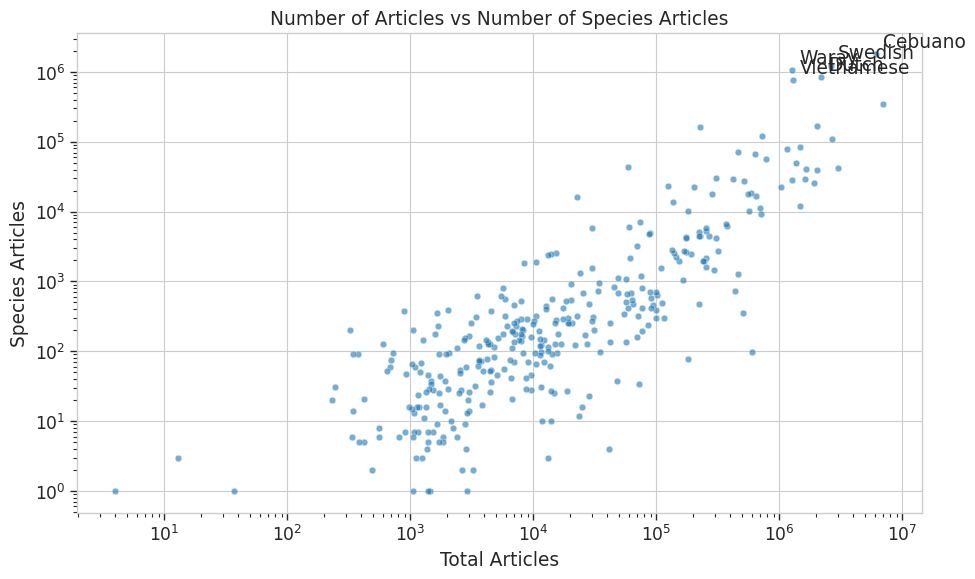


Analysis plot saved as species_articles_analysis.png


<Figure size 640x480 with 0 Axes>

In [22]:
# Analyze the merged data
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure species_count is numeric
merged_df['species_count'] = pd.to_numeric(merged_df['species_count'], errors='coerce')

# Calculate the percentage of species articles relative to total articles
merged_df['species_percentage'] = (merged_df['species_count'] / merged_df['Articles']) * 100

# Display basic statistics
print("Basic statistics of species coverage across Wikipedia languages:")
print(merged_df[['Language', 'Articles', 'species_count', 'species_percentage']].describe())

# Find top 10 languages by species count
top_by_count = merged_df.sort_values('species_count', ascending=False).head(10)
print("\nTop 10 languages by species count:")
print(top_by_count[['Language', 'species_count']])

# Find top 10 languages by species percentage
top_by_percentage = merged_df.sort_values('species_percentage', ascending=False).head(10)
print("\nTop 10 languages by species percentage (relative to total articles):")
print(top_by_percentage[['Language', 'Articles', 'species_count', 'species_percentage']])

# Create a scatter plot of Articles vs species_count
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='Articles', y='species_count', alpha=0.6)
plt.title('Number of Articles vs Number of Species Articles')
plt.xlabel('Total Articles')
plt.ylabel('Species Articles')
plt.xscale('log')
plt.yscale('log')

# Add annotations for some interesting points
for i, row in top_by_count.head(5).iterrows():
    plt.annotate(row['Language'], 
                 xy=(row['Articles'], row['species_count']),
                 xytext=(5, 5),
                 textcoords='offset points')

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig('species_articles_analysis.png')
print("\nAnalysis plot saved as species_articles_analysis.png")

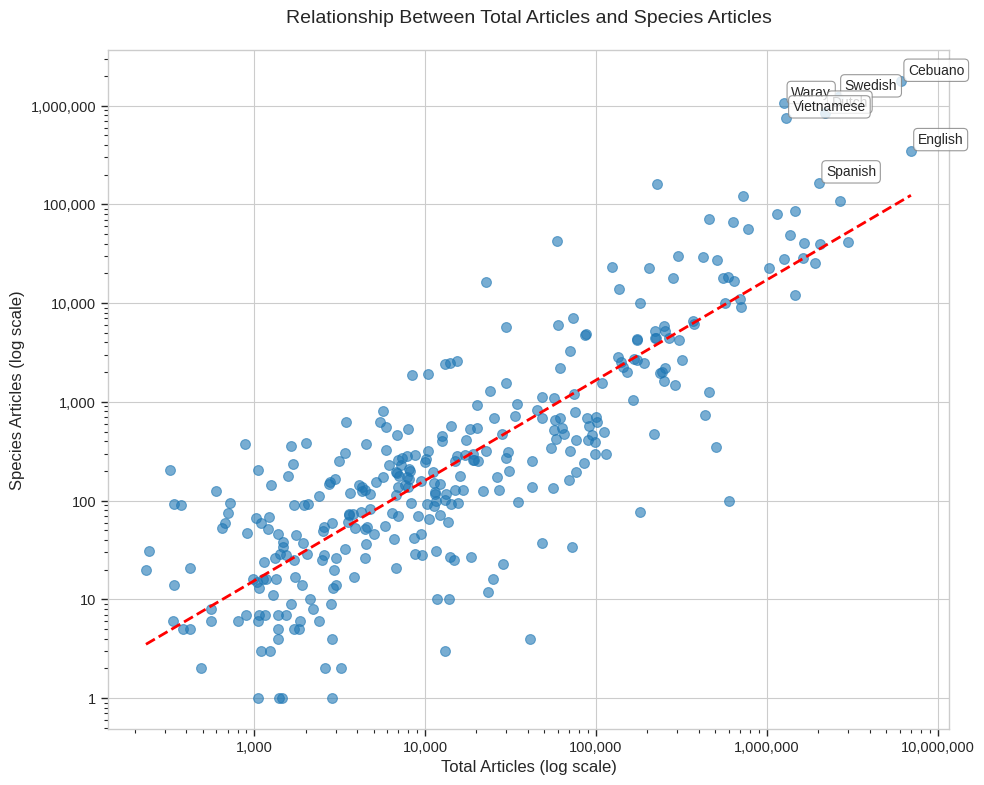

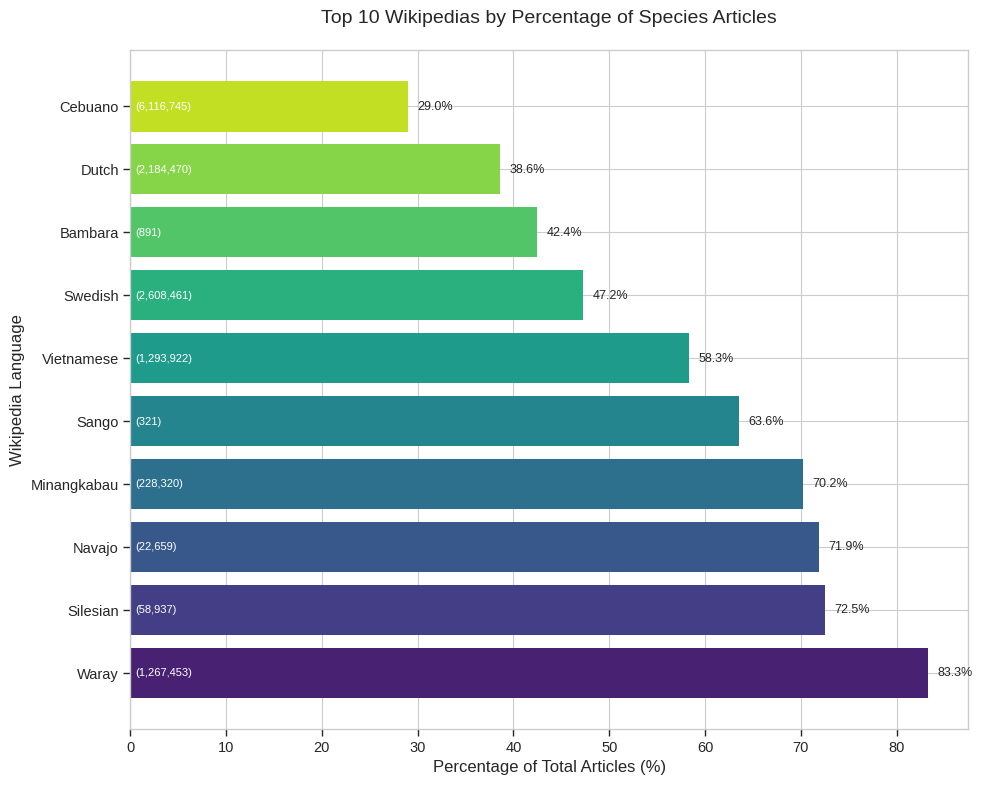

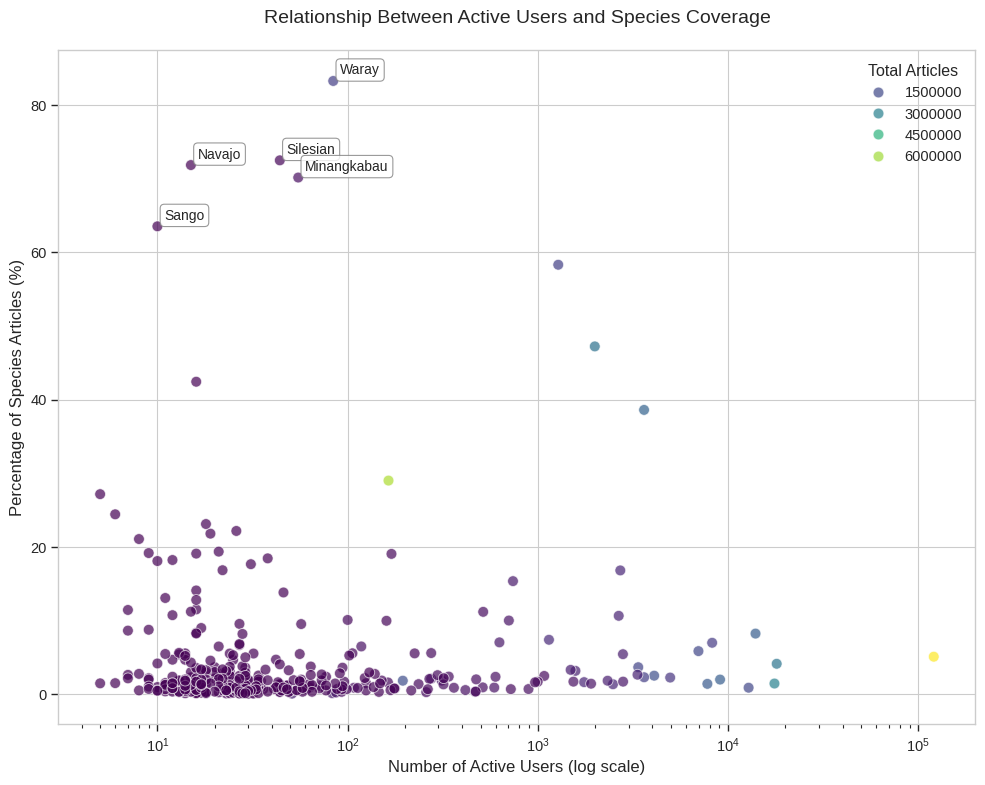

In [23]:
import numpy as np
import matplotlib.ticker as ticker

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Create a color palette
palette = sns.color_palette("viridis", 10)

# 3. A more refined scatter plot with trend line
fig, ax = plt.subplots(figsize=(10, 8))

# Filter out languages with very few articles for better visualization
filtered_df = merged_df[(merged_df['Articles'] > 100) & (merged_df['species_count'].notna())]

# Create scatter plot with log scales
ax.scatter(filtered_df['Articles'], filtered_df['species_count'], 
           alpha=0.6, s=50, color='#1f77b4')

# Add a trend line (using numpy to calculate the trend on log-transformed data)
mask = (filtered_df['Articles'] > 0) & (filtered_df['species_count'] > 0)
log_x = np.log10(filtered_df.loc[mask, 'Articles'])
log_y = np.log10(filtered_df.loc[mask, 'species_count'])

z = np.polyfit(log_x, log_y, 1)
p = np.poly1d(z)

# Generate points for the trend line
x_trend = np.logspace(np.log10(filtered_df['Articles'].min()), 
                      np.log10(filtered_df['Articles'].max()), 100)
y_trend = 10**p(np.log10(x_trend))

# Plot the trend line
ax.plot(x_trend, y_trend, 'r--', linewidth=2)

# Add annotations for interesting points
for i, row in top_by_count.head(7).iterrows():
    ax.annotate(row['Language'], 
                xy=(row['Articles'], row['species_count']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax.set_title('Relationship Between Total Articles and Species Articles', fontsize=14, pad=20)
ax.set_xlabel('Total Articles (log scale)', fontsize=12)
ax.set_ylabel('Species Articles (log scale)', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')

# Format the tick labels
def log_formatter(x, pos):
    return f'{int(x):,}' if x >= 1 else f'{x:.1f}'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_formatter))

plt.tight_layout()
plt.savefig('articles_vs_species_refined.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Horizontal bar chart of the top 10 languages by species percentage (changed from 15 to 10)
top10_by_percentage = merged_df.sort_values('species_percentage', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(top10_by_percentage['Language'], top10_by_percentage['species_percentage'], 
              color=sns.color_palette("viridis", 10))
ax.set_title('Top 10 Wikipedias by Percentage of Species Articles', fontsize=14, pad=20)
ax.set_xlabel('Percentage of Total Articles (%)', fontsize=12)
ax.set_ylabel('Wikipedia Language', fontsize=12)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 1, bar.get_y() + bar.get_height()/2,
            f'{width:.1f}%', ha='left', va='center', fontsize=9)
    
    # Add total articles count in parentheses
    articles = top10_by_percentage.iloc[i]['Articles']
    ax.text(0.5, bar.get_y() + bar.get_height()/2,
            f'({articles:,})', ha='left', va='center', fontsize=8, color='white')

plt.tight_layout()
plt.savefig('top10_by_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Relationship between active users and species coverage
fig, ax = plt.subplots(figsize=(10, 8))

# Create scatter plot
scatter = sns.scatterplot(x='Active users', y='species_percentage', 
                         data=merged_df[merged_df['species_count'].notna()], 
                         alpha=0.7, s=60, hue='Articles', palette='viridis', ax=ax)

# Add annotations for interesting points
for i, row in top_by_percentage.head(5).iterrows():
    ax.annotate(row['Language'], 
                xy=(row['Active users'], row['species_percentage']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

ax.set_title('Relationship Between Active Users and Species Coverage', fontsize=14, pad=20)
ax.set_xlabel('Number of Active Users (log scale)', fontsize=12)
ax.set_ylabel('Percentage of Species Articles (%)', fontsize=12)
ax.set_xscale('log')

# Add a colorbar legend
legend = ax.get_legend()
legend.set_title('Total Articles')

plt.tight_layout()
plt.savefig('active_users_vs_species_percentage.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for publication-quality plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=1.2)

# Get the top 10 Wikipedias by number of users
top10_by_users = merged_df.sort_values('Users', ascending=False).head(10)

# Calculate percentage of species articles
top10_by_users['species_percentage'] = (top10_by_users['species_count'] / top10_by_users['Articles']) * 100

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=top10_by_users, x='Articles', y='species_count', s=100, alpha=0.7)

# Add labels for each point with language code and percentage
for i, row in top10_by_users.iterrows():
    plt.annotate(f"{row['Wiki']} ({row['species_percentage']:.1f}%)", 
                xy=(row['Articles'], row['species_count']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)

# Add a title and labels
plt.title('Species Articles vs Total Articles for Top 10 Wikipedias by Users', fontsize=14)
plt.xlabel('Total Articles', fontsize=12)
plt.ylabel('Species Articles', fontsize=12)

# Add a grid
plt.grid(True, alpha=0.3)

# Add a trend line
sns.regplot(data=top10_by_users, x='Articles', y='species_count', 
           scatter=False, ci=None, line_kws={"color": "red", "linestyle": "--"})

# Calculate the average percentage for the trend line
avg_percentage = top10_by_users['species_percentage'].mean()

# Add text about the average percentage
plt.text(0.5, 0.05, f"Average: {avg_percentage:.1f}%)", 
         transform=plt.gca().transAxes, ha='center', 
         bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="red", alpha=0.8))

# Format the axes with commas for thousands
plt.ticklabel_format(style='plain', axis='both')
ax = plt.gca()
ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()
plt.savefig('top10_users_articles_vs_species.png', dpi=300, bbox_inches='tight')
plt.show()

SyntaxError: '(' was never closed (2624038042.py, line 20)

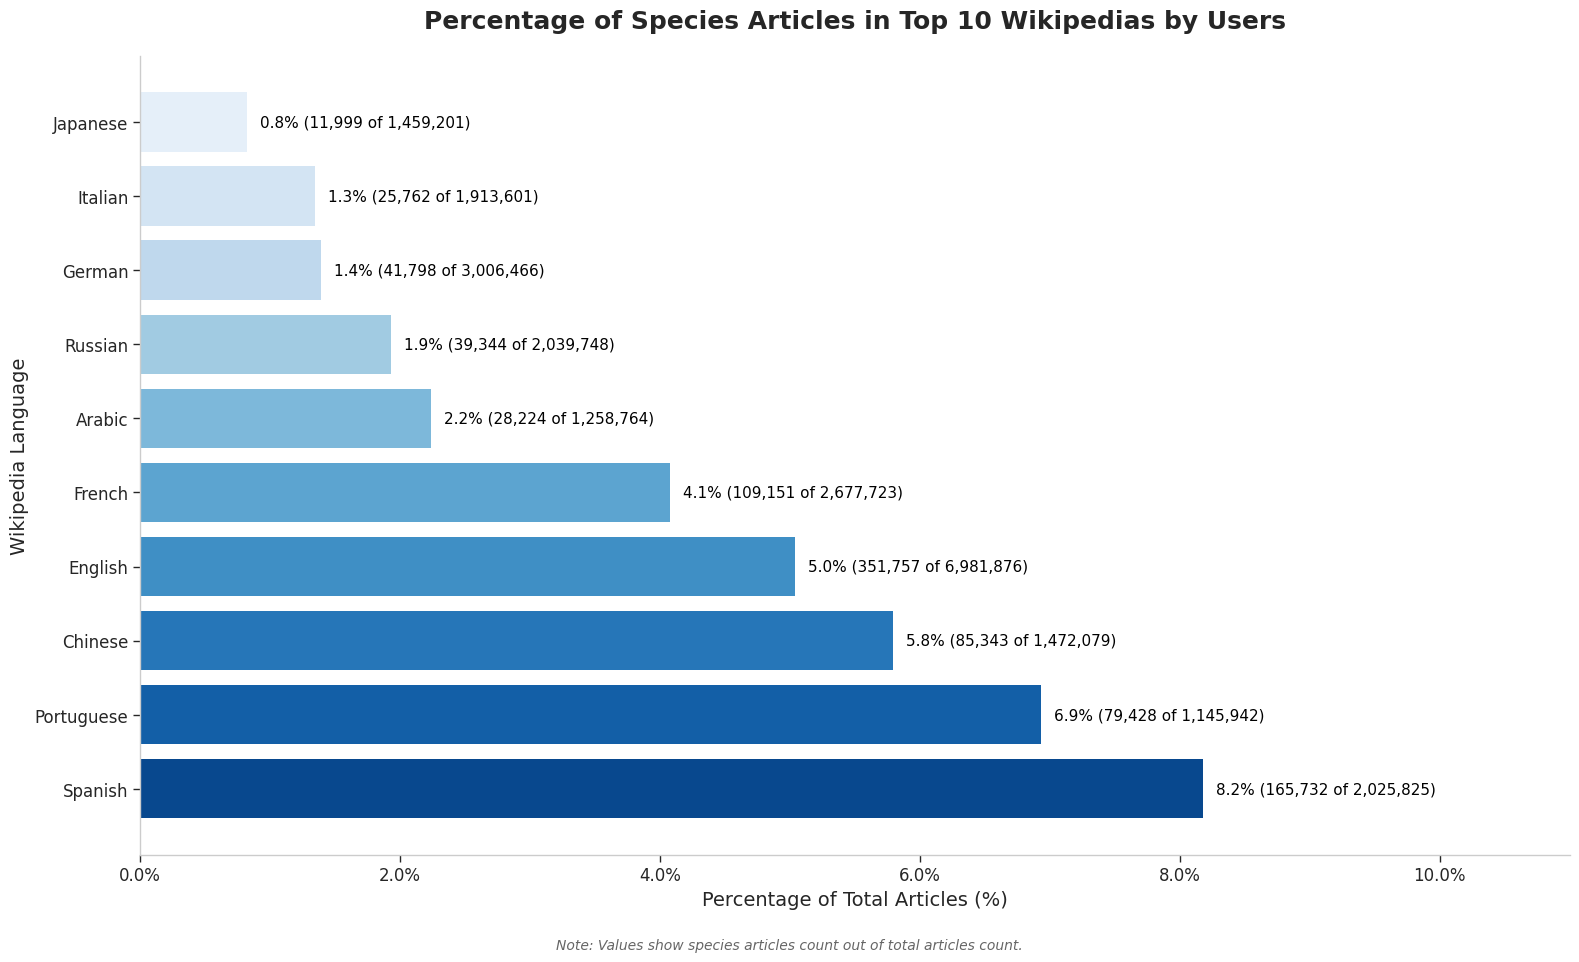

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the style for a clean, professional plot
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans']
})

# Get the top 10 Wikipedias by number of users
top10_by_users = merged_df.sort_values('Users', ascending=False).head(10)

# Calculate percentage of species articles
top10_by_users['species_percentage'] = (top10_by_users['species_count'] / top10_by_users['Articles']) * 100

# Sort by percentage for better visualization
top10_by_users_sorted = top10_by_users.sort_values('species_percentage', ascending=False)

# Create a horizontal bar chart with clean aesthetics
fig, ax = plt.subplots(figsize=(16, 10))

# Use a more sober color palette (blues)
colors = sns.color_palette("Blues_r", 10)

# Create the horizontal bars
bars = ax.barh(top10_by_users_sorted['Language'], top10_by_users_sorted['species_percentage'], 
               color=colors, edgecolor='none')

# Add a title and labels with clean styling
ax.set_title('Percentage of Species Articles in Top 10 Wikipedias by Users', 
             fontsize=18, pad=20, fontweight='bold')
ax.set_xlabel('Percentage of Total Articles (%)', fontsize=14)
ax.set_ylabel('Wikipedia Language', fontsize=14)

# Improve tick labels
ax.tick_params(axis='both', which='major', labelsize=12)

# Remove all grid lines for a cleaner look
ax.grid(False)

# Add value labels with article counts after percentages
for i, bar in enumerate(bars):
    width = bar.get_width()
    articles = top10_by_users_sorted.iloc[i]['Articles']
    species = top10_by_users_sorted.iloc[i]['species_count']
    
    # Format the text with percentage followed by article counts
    label_text = f'{width:.1f}% ({int(species):,} of {int(articles):,})'
    
    # Add the label after the bar
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2,
            label_text, 
            ha='left', va='center', 
            fontsize=11, color='black')

# Remove the top and right spines for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Format x-axis to show percentages clearly
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=100, decimals=1))

# Set x-axis limits to ensure consistent spacing
ax.set_xlim(0, 11)  # Set max to 11% to leave room for labels

# Add more space for y-axis labels
plt.subplots_adjust(left=0.2)

# Add a caption as text at the bottom
fig.text(0.5, 0.01, 
         "Note: Values show species articles count out of total articles count.", 
         ha='center', fontsize=10, style='italic', color='#666666')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig('top10_users_species_percentage.png', dpi=300, bbox_inches='tight')
plt.show()